# Theft Crime Prediction using KDE Tweets in Cicago

In [1]:
%matplotlib inline

import os
import glob
import itertools
import functools
import collections

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook, tqdm

from utils.consts import START_DATE, END_DATE, \
                         RAW_CRIMES_DATA_PATH, PROCESSED_CRIMES_DATA_PATH, \
                         RAW_TWEETS_DATA_WILDCARD_PATH, PROCESSED_TWEETS_DATA_PATH, \
                         CSV_DATE_FORMART

from utils.lda import print_top_words_LDA, print_top_words_LDA, get_topic_top_words_LDA

from utils.surveillance import generate_all_data_surveillance_data, \
                               generate_one_step_datasets, generate_surveillance_data, calc_AUCs
    
from utils.visualization import plot_contour, plot_scatter, plot_imshow, plot_log_reg_coef, plot_surveillance_data


In [2]:
import warnings
warnings.simplefilter('ignore')

## Pipline Diagram

![title](./ANLP-Project-Pipeline.png)

## Research Time Frame

In [3]:
print(START_DATE, '--->', END_DATE)

2017-12-08 ---> 2018-02-19


## Data Sources & Preprocessing

### Chicago Crimes Incidents (only THEFT)

In [4]:
if not os.path.exists(PROCESSED_CRIMES_DATA_PATH):
    !python3 ./preprocess_crimes_data.py {RAW_CRIMES_DATA_PATH}  {PROCESSED_CRIMES_DATA_PATH}

In [5]:
crimes_data = pd.read_csv(PROCESSED_CRIMES_DATA_PATH)
crimes_data['timestamp'] = pd.to_datetime(crimes_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()

In [6]:
len(crimes_data)

10902

In [7]:
crimes_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

### Tweets

In [8]:
if not os.path.exists(PROCESSED_TWEETS_DATA_PATH):
    !python3 -W ignore ./preprocess_tweets_data.py {RAW_TWEETS_DATA_WILDCARD_PATH} {PROCESSED_TWEETS_DATA_PATH}

In [9]:
tweets_data = pd.read_csv(PROCESSED_TWEETS_DATA_PATH)
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'], format=CSV_DATE_FORMART).dt.normalize()
tweets_data['tokens'] = tweets_data['tokens'].apply(lambda x: eval(x))

In [10]:
len(tweets_data)

79634

In [11]:
tweets_data['timestamp'].agg(['min', 'max'])

min   2017-12-08
max   2018-02-19
Name: timestamp, dtype: datetime64[ns]

### Enreaching every Tweet with Sentiment Analysis

For **demonstration propuse**, the training and evaluation of the Sentiment Analysis Model is done every time the notebook is executed.
The same goes for calculating the sentiment value for each tweet.

In [12]:
%%time

from utils.sentiment.sentiment import calculate_sentiment_tweet

Length of the testing Corpus : 10662
Adding unigrams and bigrams sentiment scores 

average fit_time : 0.46118597984313964
average score_time : 0.009061503410339355
average test_f1_micro : 0.7554900886087512
average test_f1_macro : 0.7554053496579932
average test_precision_micro : 0.7554900886087512
average test_precision_macro : 0.7558688268181593
average test_recall_micro : 0.7554900886087512
average test_recall_macro : 0.7554900886087512
CPU times: user 9 s, sys: 323 ms, total: 9.32 s
Wall time: 10.6 s


In [13]:
%%time

tweets_data['sentiment'] = tweets_data['tokens'].apply(lambda x: calculate_sentiment_tweet(' '.join(x)))

CPU times: user 1min 44s, sys: 1.32 s, total: 1min 45s
Wall time: 1min 55s


## Detailed analysis of 31 days training dataset and the successive single day for evaluation

### Generating the train dataset with all the features (KDA, SENTIMENT, LDA) and the evaluation dataset (successive day crime incidents)

In [14]:
%%time

train_dataset, evaluation_dataset = generate_one_step_datasets(crimes_data,
                                                               tweets_data,
                                                               START_DATE,
                                                               31)

CPU times: user 3min 27s, sys: 12.4 s, total: 3min 40s
Wall time: 3min 17s


#### KDE

Text(0.5,1,'Crime Incidents: 2017-12-08+31 days')

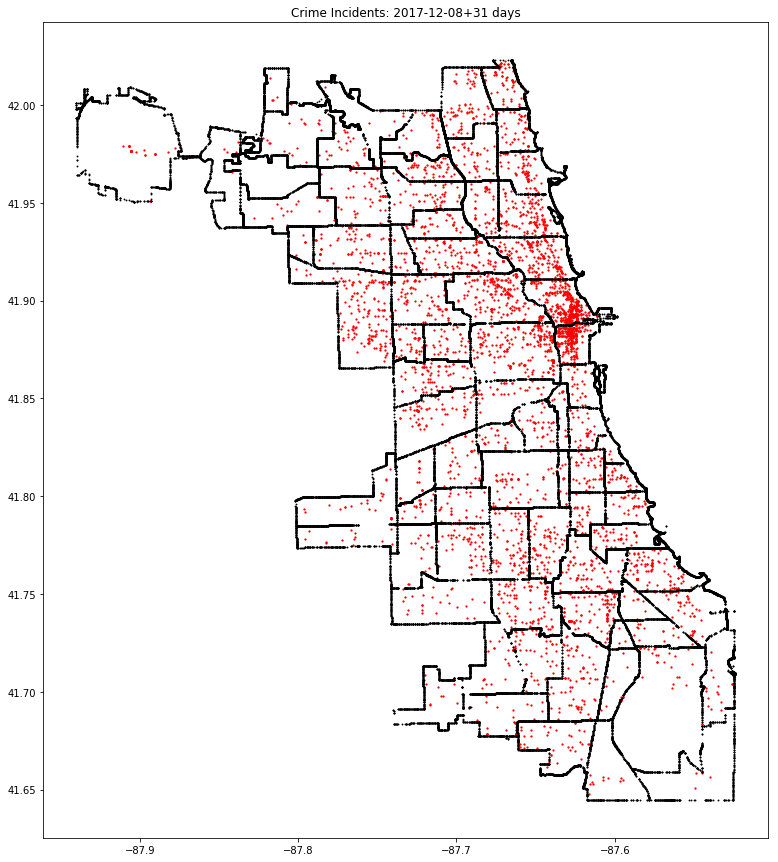

In [15]:
plot_scatter(train_dataset['X'][train_dataset['Y']][['latitude', 'longitude']])
plt.title('Crime Incidents: {}+31 days'.format(START_DATE))

Text(0.5,1,'KDE of Crime Incidents: 2017-12-08+31 days')

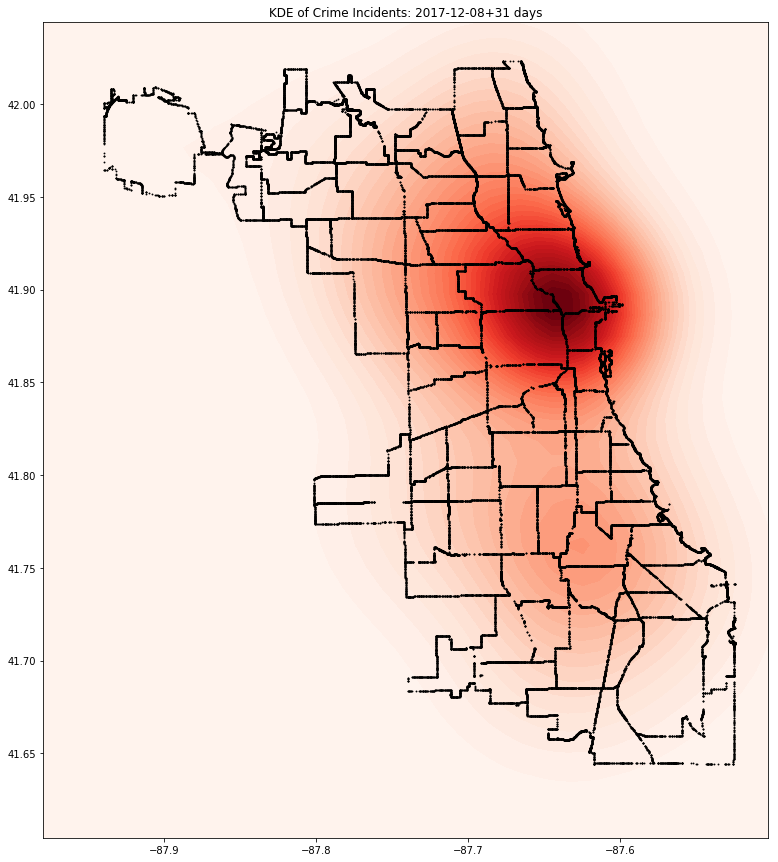

In [16]:
plot_contour(train_dataset['KDE'])
plt.title('KDE of Crime Incidents: {}+31 days'.format(START_DATE))

#### Sentiment

Text(0.5,1,'Sentiment Histogram & Distribution over Geo Documents')

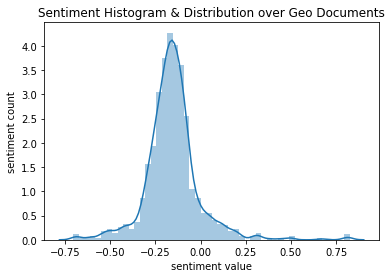

In [17]:
sns.distplot(train_dataset['SENTIMENT'], norm_hist=True)
plt.xlabel('sentiment value')
plt.ylabel('sentiment count')
plt.title('Sentiment Histogram & Distribution over Geo Documents')

#### LDA

In [18]:
print_top_words_LDA(train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 5)

Topic #0: mind | institution | . | … | url
Topic #2: old | New | url | Year’s | yr
Topic #4: url | IL | , | I'm | Chicago
Topic #5: url | … | , | . | Chicago
Topic #6: url | ” | “ | BABY | !…
Topic #7: Ridge | url | … | , | Burr
Topic #8: DAMN | mess | doing | y'all | use
Topic #10: url | , | : | IL | -
Topic #11: url | … | Chicago | . | ,
Topic #12: Ramp | Inbound | url | Grange | 🙏🏼
Topic #13: url | … | . | , | !
Topic #16: url | … | Channel | ! | videos
Topic #17: url | Baseball | Academy | B.I.G. | …
Topic #18: da | Ba | Trainee | 4 | Management
Topic #19: url | , | … | ! | Oak
Topic #20: 13mm | 16mm | lashes | went | The
Topic #23: Chicago | url | , | IL | Airport
Topic #24: url | Avenue | North | West | New
Topic #25: 🐎 | Tap | Guide's | Grill | Shot
Topic #26: url | , | IL | : | !
Topic #27: Training | joining | thank | welcome | 🧦
Topic #29: url | Center | United | game | theogdenchicago
Topic #34: . | Fashion | url | Clothing | House
Topic #35: -> | , | wind | humidity | :
Top

Lets try to examine one "interesting" topic vector. First we check which ones have the maximal variance in its values.

In [19]:
print(np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[::-1][:5])

[ 10 237   5 304   4]


Lets pick up the maximal one in this sense.

In [20]:
exmple_topic_id = np.argsort(train_dataset['LDA']['model'].components_.std(axis=1))[-1]
print(exmple_topic_id)
example_topic_column_name = 'T{:03}'.format(exmple_topic_id)

10


In [21]:
get_topic_top_words_LDA(exmple_topic_id, train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)

['url',
 ',',
 ':',
 'IL',
 '-',
 '?',
 '…',
 '!',
 'latest',
 'work',
 'opening',
 "We're",
 'recommend',
 'Can',
 'great']

## Crime Prediction

In [22]:
surveillance_data, threat_datasets = generate_surveillance_data(train_dataset,
                                                                evaluation_dataset)

### Logic Regression Coefficients
*Note: All features were standatarized, therefore there is a meaning for coefficeints comparing.*

#### SENTIMENT model

Most dominant coefs indices: [1 0]


1

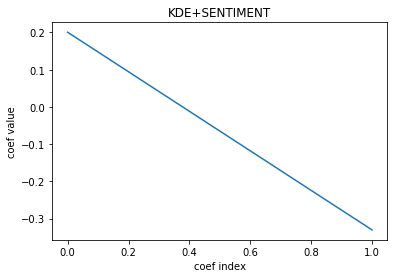

In [23]:
plot_log_reg_coef(threat_datasets, 'KDE+SENTIMENT')

#### KDE+LDA model

Most dominant coefs indices: [  7  73 159  88  17]


7

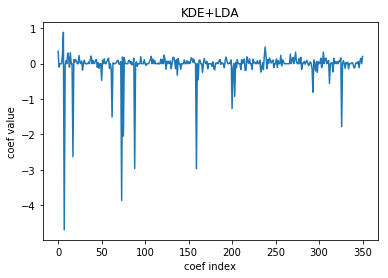

In [24]:
plot_log_reg_coef(threat_datasets, 'KDE+LDA')

#### KDE+SENTIMENT+LDA model

Most dominant coefs indices: [  8  74  89 160  18]


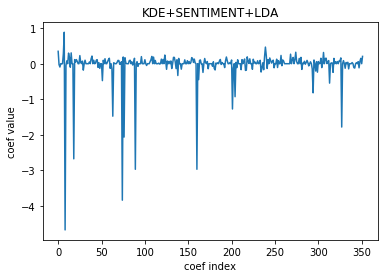

In [25]:
most_dominant_coefs_index = plot_log_reg_coef(threat_datasets, 'KDE+SENTIMENT+LDA') - 2

Examining the top words for the most dominant logistic regression coefficent topic:

In [26]:
get_topic_top_words_LDA(most_dominant_coefs_index,
                        train_dataset['LDA']['model'], train_dataset['LDA']['vocabulary'], 15)


['url',
 '”',
 '“',
 'BABY',
 '!…',
 '…',
 'results',
 '😘',
 'Only',
 'You',
 'Once',
 "Lalo's",
 'home',
 'Birthday',
 'need']

### Surveillance Plot & AUC

In [27]:
normalized_surveillance_data = surveillance_data.cumsum(axis=1) / surveillance_data.sum(axis=1)[:, None]

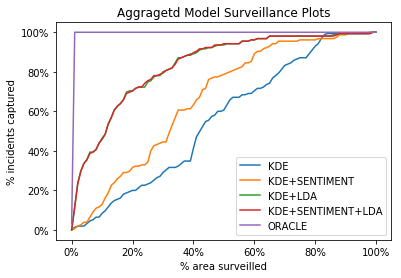

In [28]:
plot_surveillance_data(normalized_surveillance_data, threat_datasets.keys())

In [29]:
print('AUC betwwen models')
calc_AUCs(normalized_surveillance_data, threat_datasets.keys())

AUC betwwen models


,KDE,KDE+SENTIMENT,KDE+LDA,KDE+SENTIMENT+LDA
KDE+SENTIMENT,0.107057,,,
KDE+LDA,0.275940,0.168883,,
KDE+SENTIMENT+LDA,0.276019,0.168963,0.000080,
ORACLE,0.440343,0.333286,0.164403,0.164323


## Full Training & Evaluation over all the period (~60 steps of 31 days)
**TAKES ~3 HOURS, CHANGE THE VARIABLE `is_full_run` TO `True` IN ORDER TO PREFORM IT**

In [ ]:
is_full_run = True

In [ ]:
if is_full_run:
    agg_surveillance_data, all_threat_datasets = generate_all_data_surveillance_data(crimes_data, tweets_data, 31)   

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
if is_full_run:
    plot_surveillance_data(agg_surveillance_data, all_threat_datasets[0][1].keys())

In [ ]:
if is_full_run:
    print('AUC betwwen models')
    calc_AUCs(agg_surveillance_data, all_threat_datasets[0][1].keys())